![](https://raw.githubusercontent.com/unm-escape/escape2022/main/header2.png)

<h1 style="text-align:center; color:#3333ff;">Plotting seismic reflection data and picking arrivals</h1>
<br>
<div style="text-align:center; font-size:16px">
    Earth and Planetary Sciences,<br>
    University of New Mexico<br>
    <br>
    August 14, 2023
</div>

---
**Tutorial Outline:**
1. Reading SEG-Y data from file<br>
2. Updating header info<br>
3. Applying simple amplitude attenuation correction<br>
4. Picking arrivals<br>
---
**Dependencies:** Obspy, Numpy, Matplotlib and the Utils script

---

<font size="4.5">**1. Reading SEG-Y data from file**</font><br>

Having looked at earthquake seismograms, the goal of this exercise is to quickly look at seismic reflection data while leveraging the Obspy and Matplotlib skills you acquired in previous lectures.

There are more robust python and non-python open-source frameworks for processing seismic reflection data. I recommend [Seismic Unix](https://wiki.seismic-unix.org/doku.php) and [Madagascar](https://reproducibility.org/wiki/Main_Page).

<font size="4.5">Importing required modules:</font><br>

The Utils module is a custom file containing several functions we will need to handle the SEG-Y files. Modules allow for breaking large programs into small manageable files and makes code reusable. 

Let's start by importing required modules.

In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from obspy import Stream, read

# If you go to the file utils.py in your day6 folder, 
# you will see definitions of these functions
from utils import pick_segy, plot_segy, plot_segy_picks, gain 

Read the SEG-Y data into a [Stream object](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html#obspy.core.stream.Stream) by supplying obspy [read function](https://docs.obspy.org/packages/autogen/obspy.core.stream.read.html) with the path to the SEG-Y file on your computer.

The dataset we are using in this exercise, known as the OZ-25 dataset, is widely used in the geophysics community. The data are available at the [Seismic Unix website](https://wiki.seismic-unix.org/tutorials:data) and the [madagascar website](https://www.reproducibility.org/wiki/Main_Page).

In [2]:
stream = read('./ozdata_25.segy', format='SEGY',unpack_trace_headers=True)

print(stream)

96 Trace(s) in Stream:

Seq. No. in line:    1 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:04.198000Z | 500.0 Hz, 2100 samples
...
(94 other traces)
...
Seq. No. in line:   96 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:04.198000Z | 500.0 Hz, 2100 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


#### The "stream" is much like the data we downloaded from global seismic networks.

<pre>




</pre>

#### Let's grab the first trace object and view a summary its metadata.

In [3]:
tr = stream[0]
print(tr)


Seq. No. in line:    1 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:04.198000Z | 500.0 Hz, 2100 samples


<pre>




</pre>

#### Let's view the actual data of the first trace

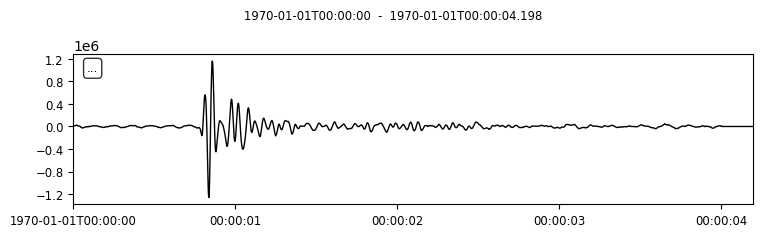

In [4]:
single_trace = tr.plot()

---
<font size="4.5">**2. Updating header info**</font><br>

![shot gather](https://subsurfwiki.org/images/3/3f/Example_shot_gather.jpg)

The data is a **shot gather** with a time sampling rate of 0.002s and receiver spacing of 0.05 km (50 m). The shot location is at the center of the array. 

The geometry information of the OZ-25 data isn't assigned, so let's update the receiver location, source location and the offset assuming a 2-D line.

In [5]:
sx = ((len(stream)-1) * 50)/2 # source x coordinate

gx = 0 # Initialize receiver 1 x coordinate at 0 m

# Loop throught the stream
for tr in stream:
    tr.stats.segy.trace_header.group_coordinate_x = gx
    tr.stats.segy.trace_header.source_coordinate_x = sx
    tr.stats.segy.trace_header.distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group = gx-sx
    gx += 50

print("Update done!")

Update done!


---
<font size="4.5">**3. Applying simple amplitude attenuation correction**</font><br>

Seismic amplitude is the magnitude of the wiggles in a seismic record. The amplitude of seismic data depends on the source, receiver, and the medium in which the waves are propagating.

In active source reflection seismology, we account for seismic wave amplitude loss due to transmission, absorption and spherical spreading by applying offset and time dependent gain.

#### Let's plot the raw shot gather with the plot_segy function:

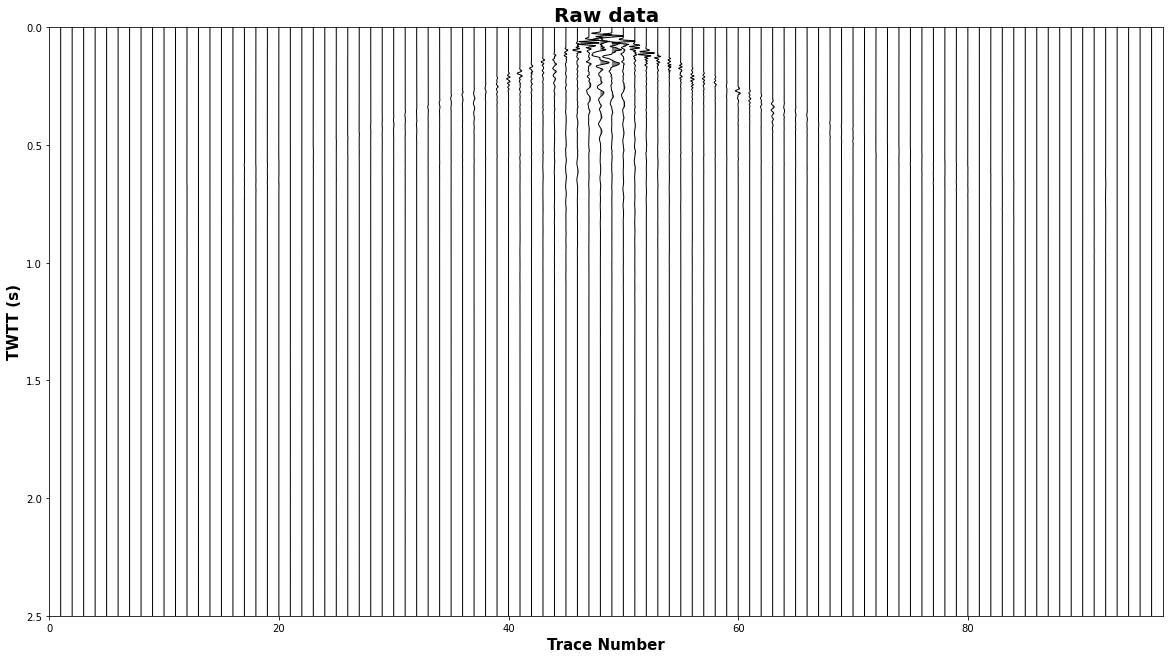

In [6]:
## Plot raw traces
startTime = 0.0
endTime = 2.5
plot_segy(stream, normalizeGlobal=True, 
          scale=1, title='Raw data', tstart=startTime, tend=endTime, saveFigure=False)

---
#### This plot shows the raw data without any gain applied.

**Gain** is amplitude correction applied to the seismic data. There are data-independent and data-dependent amplitude correction methods. In data-independent techniques, the scaling function is not derived from the amplitude information in the data.

An example of a data-independent method is the $t^{2}$ method where each trace's data is multiplied by the square of the two-way travel time (Yilmaz, 2001).

Use the gain function from the Util module to apply the $t^{2}$ gain:

---

In [7]:
gainedStream = gain(stream, normalizeTraces=False)



Use the plot_segy function from the Util module to plot the $t^{2}$ gained dataset.

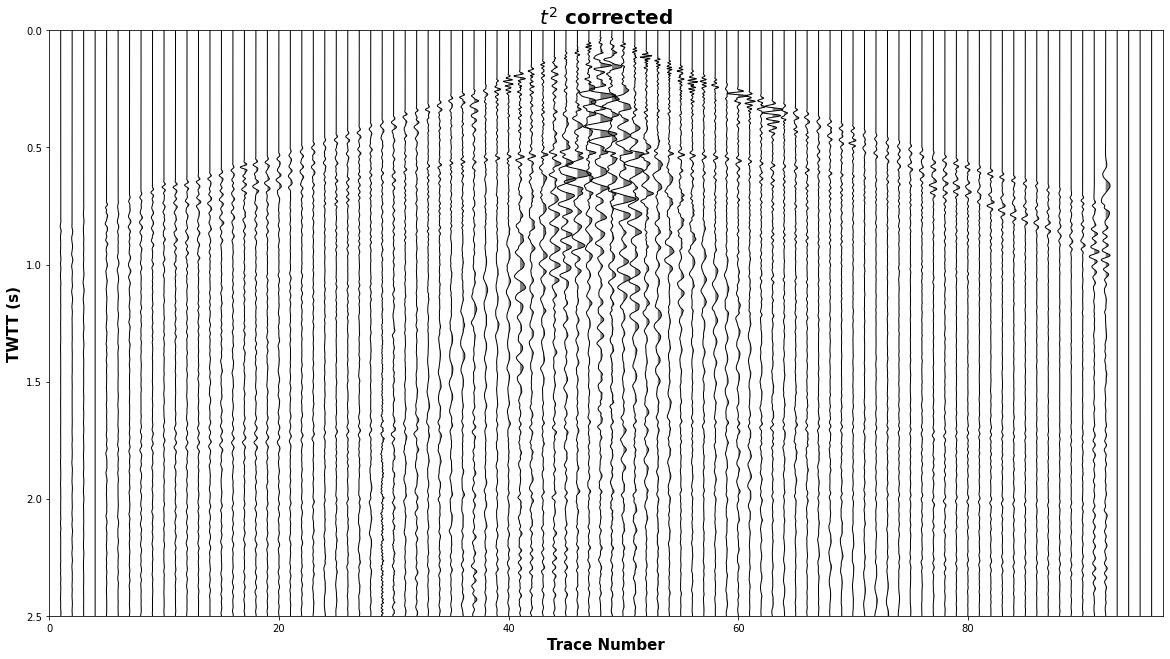

In [8]:
startTime = 0.0
endTime = 2.5
plot_segy(gainedStream, scale=1.5, title='$t^{2}$ corrected', 
          tstart=startTime, tend=endTime, saveFigure=False)

---
<font size="4.5">**4. Picking arrivals**</font><br>
<br>

![](https://raw.githubusercontent.com/unm-escape/escape2022/main/day08_Aug17/schematic.png)

Now we identify the phases and pick the arrivals.

First let's isolate one half of the raw and gained shot gather.

In [9]:
half_offset = Stream()
for tr in stream:
    if tr.stats.segy.trace_header.distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group >= 0:
        half_offset += tr
        
half_offset_gained = Stream()
for tr in gainedStream:
    if tr.stats.segy.trace_header.distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group >= 0:
        half_offset_gained += tr

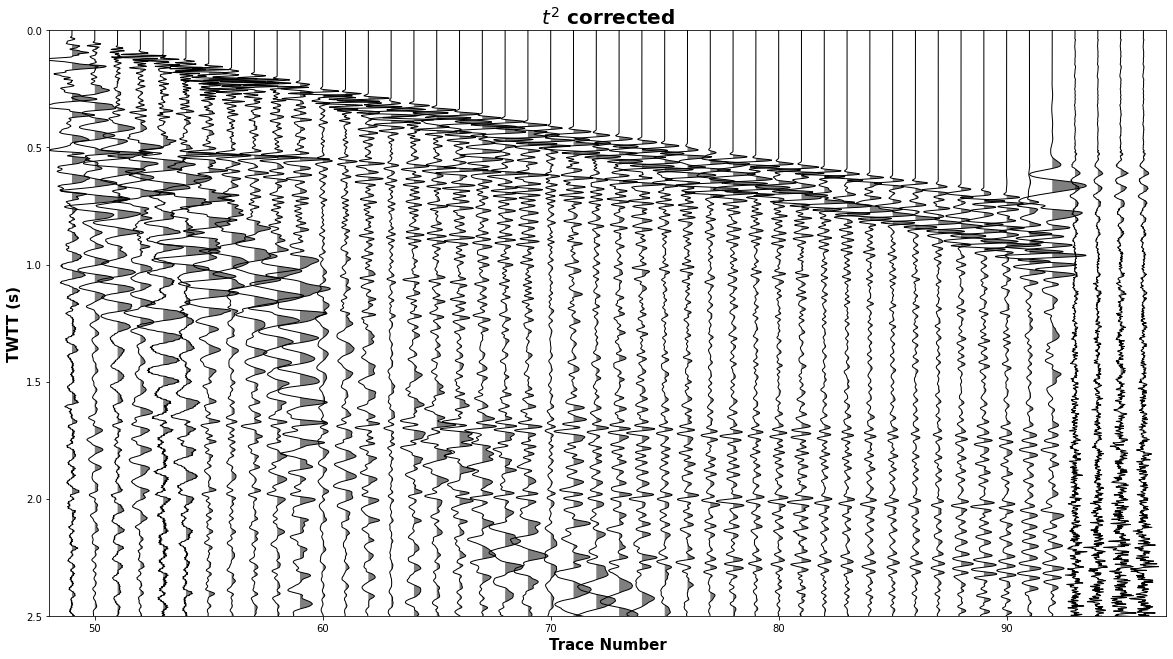

In [10]:
plot_segy(half_offset_gained, scale=1.5, title='$t^{2}$ corrected', normalizeTraces=True,
          tstart=startTime, tend=endTime, saveFigure=False)

#### Pick the direct wave. 

**Heads up, operating the graphical interface can be tricky - it is prone to freezing.**
Tips:
1. Expand the window - don't zoom or change any settings. <br>
2. Only click once per trace, where you would like to select the arrival. Do this slowly to avoid freezing the interface <br>
3. When you are done hit the Enter/Return button on your keyboard and minimize the picking window. <br>
4. Do not close the picking window or it may cause your program to crash. 

In [11]:
## Pick first arrival
startTime = 0.0
endTime = 1.0
dw_trc_nums, dw_picks, dw_offsets = pick_segy(half_offset, normalizeTraces=True, normalizeGlobal=False, scale=1.5, 
                                          title=None, tstart=startTime, tend=endTime, 
                                          saveFigure=False)

Success! Picks Ready.


---
#### Pick_segy outputs three list variables
1) dw_tr_nums - list of pick trace numbers
2) dw_picks   - list of time picks
3) dw_offets  - list of offset distance between the picked trace and source
---


In [12]:
print('Picked channels are', dw_trc_nums, '\n')
print('Picked times are', np.round(dw_picks,4), 'seconds \n')
print('Picked offsets are', dw_offsets, 'meters')

Picked channels are [ 49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  64.  72.  78.  85.
  90.] 

Picked times are [ 0.0217  0.043   0.0627  0.0824  0.1004  0.1168  0.1431  0.1595  0.1792
  0.1956  0.212   0.3039  0.4204  0.5222  0.6206  0.6928] seconds 

Picked offsets are [25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0, 475.0, 525.0, 775.0, 1175.0, 1475.0, 1825.0, 2075.0] meters


#### Plot the picks on the half-offset gathers

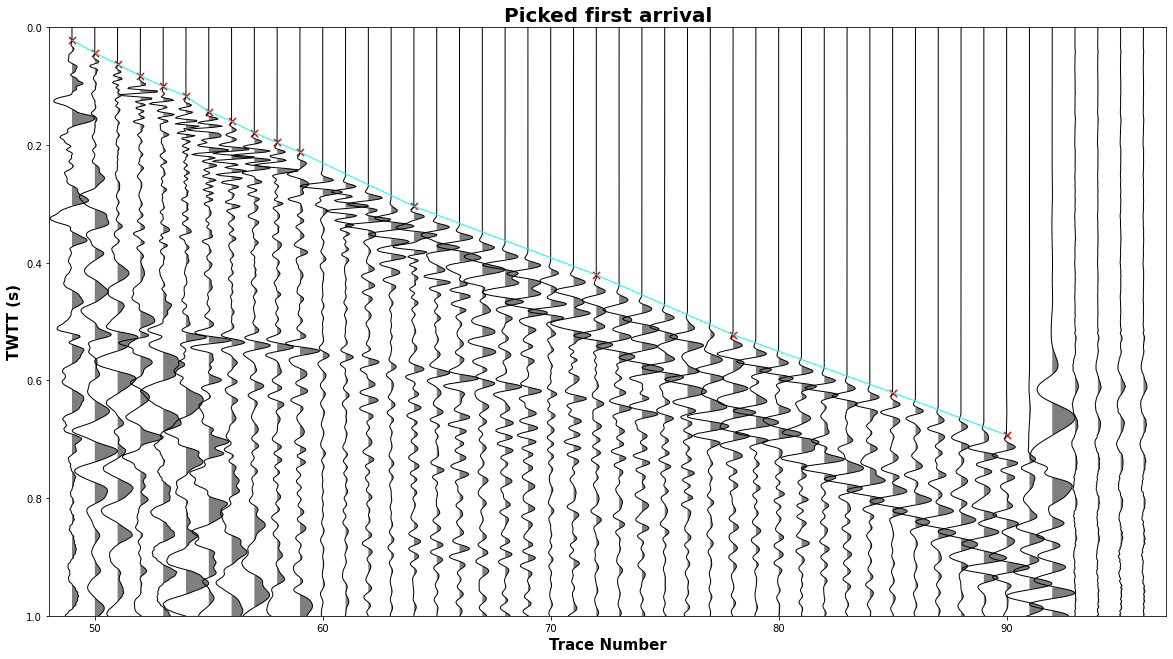

In [13]:
## Plot picks
%matplotlib inline
plot_segy_picks(half_offset_gained, normalizeTraces=True, normalizeGlobal=False, scale=1, title='Picked first arrival', 
                tstart=0, tend=1, picksX=dw_trc_nums, picksY=dw_picks, saveFigure=True)

#### Create a T-X plot with your picks. 
By fitting a line to our first arrival, we create a very simple **model** for the average P-wave velocity along the fastest path. <br>

The function ***np.polyfit(x,t,1)*** takes two numerical lists and finds a linear function of best-fit. <br>

We can then use ***np.poly1d()*** to calculate a function for calculating lines of best-fit.

In [14]:
# Estimate model from picks and offsets
coeffs = np.polyfit(dw_offsets,dw_picks,1)
print(coeffs, 'correspond to the slope (seconds/meter) and t-intercept (seconds)')


# Create the poly1d_fn function which takes in x and returns an estimate for y
poly1d_fn = np.poly1d(coeffs)


[ 0.00032714  0.03064749] correspond to the slope (seconds/meter) and t-intercept (seconds)


<pre>




</pre>
#### Plot the model and picks

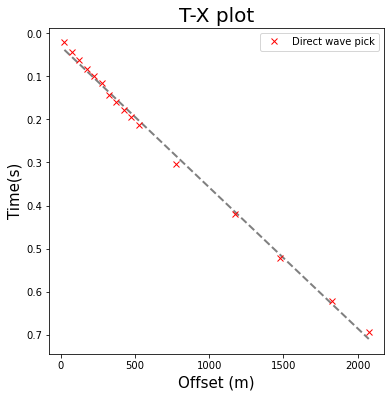

In [15]:
fig, axs = plt.subplots(figsize=(6,6))
plt.axis('off')

ax = fig.add_subplot()
ax.plot(dw_offsets, dw_picks, 'rx', label='Direct wave pick')
ax.plot(dw_offsets, poly1d_fn(dw_offsets), '--k', lw=2.0, zorder=1, alpha=0.5)

ax.set_xlabel('Offset (m)', fontsize=15)
ax.set_ylabel('Time(s)', fontsize=15)
plt.title('T-X plot', fontsize=20)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

<pre>




</pre>
#### Use Numpy's polyfit function to calculate $V_{0}$

**t = mx + b**


In [16]:

m, b = np.polyfit(dw_offsets, dw_picks, 1)

print('V\N{SUBSCRIPT ZERO} = ' + str(round(1/m, 0)) + ' m/s')

V₀ = 3057.0 m/s


<pre>




</pre>

#### Use the pick_segy function to pick the first strong reflected wave - same procedure as the first arrival.

In [17]:
## Pick reflected wave
startTime = 0.0
endTime = 1.0
rw_trc_nums, rw_picks, rw_offsets = pick_segy(half_offset_gained, normalizeTraces=True, normalizeGlobal=False, scale=1, 
                                          title=None, tstart=startTime, tend=endTime, saveFigure=False)

Success! Picks Ready.


#### Plot reflected wave picks on the half-offset gathers

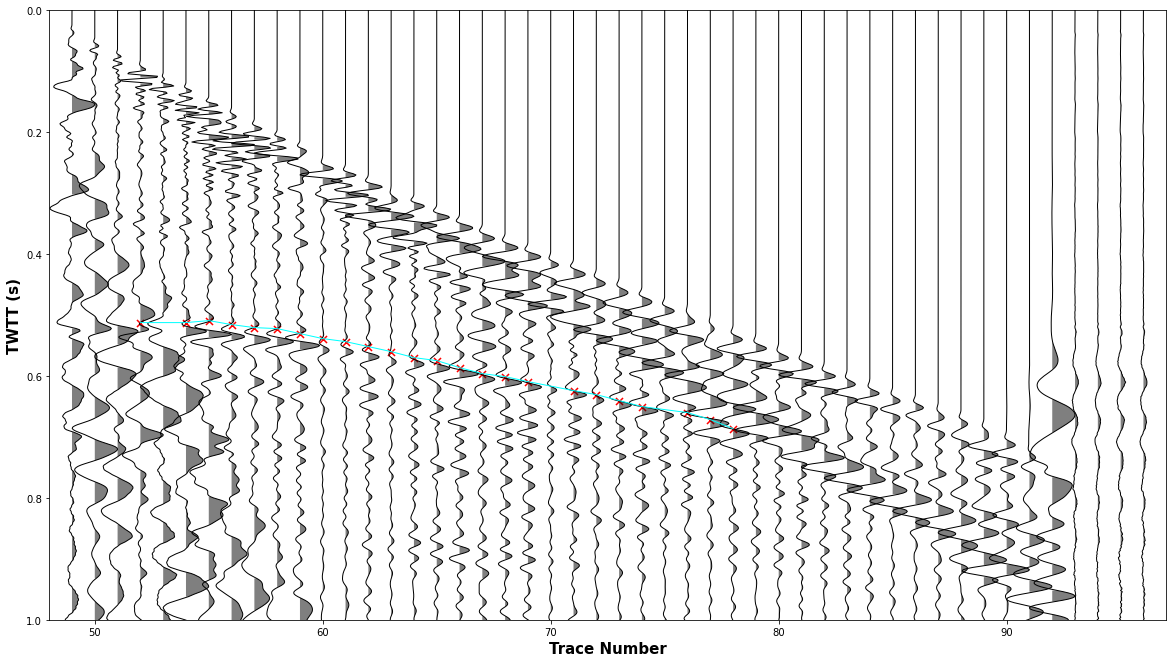

In [18]:
## Plot picks
%matplotlib inline
plot_segy_picks(half_offset_gained, normalizeTraces=True, normalizeGlobal=False, scale=1, title=None, 
                tstart=0, tend=1, picksX=rw_trc_nums, picksY=rw_picks, saveFigure=False)

<pre>




</pre>
#### Plot the model and picks

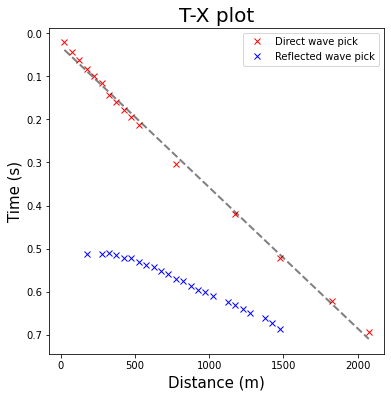

In [19]:
%matplotlib inline
fig, axs = plt.subplots(figsize=(6,6))
plt.axis('off')
ax = fig.add_subplot()

ax.plot(dw_offsets, dw_picks, 'rx', zorder=1, label='Direct wave pick')
ax.plot(dw_offsets, poly1d_fn(dw_offsets), '--k', lw=2.0, zorder=2, alpha=0.5)
ax.plot(rw_offsets, rw_picks, 'bx', zorder=3, label='Reflected wave pick')

ax.set_xlabel('Distance (m)', fontsize=15)
ax.set_ylabel('Time (s)', fontsize=15)
plt.title('T-X plot', fontsize=20)
plt.legend()
plt.gca().invert_yaxis()
plt.show()

#### We cannot fit a straight line to the reflection - we have to fit a hyperbola. 

**This means we find a linear relationship between time and distance squared.**

Create a $T^{2}$-$X^{2}$ plot of reflected picks.

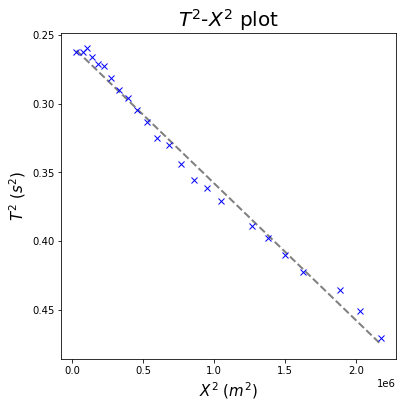

In [20]:
t_squared = np.square(rw_picks)
x_squared = np.square(rw_offsets)

#m, b = np.polyfit(offsets, time_picks,1)
rw_coeffs = np.polyfit(x_squared, t_squared, 1)
# Create the poly1d_fn function which takes in x and returns an estimate for y
rw_poly1d_fn = np.poly1d(rw_coeffs)

%matplotlib inline
fig, axs = plt.subplots(figsize=(6,6))
plt.axis('off')
ax = fig.add_subplot()
ax.plot(x_squared, t_squared, 'bx', zorder=2)
ax.plot(x_squared, rw_poly1d_fn(x_squared), '--k', lw=2.0, zorder=1, alpha=0.5)
ax.set_xlabel('$X^{2}$ ($m^{2}$)', fontsize=15)
ax.set_ylabel('$T^{2}$ ($s^{2}$)', fontsize=15)
plt.title('$T^{2}$-$X^{2}$ plot', fontsize=20)
plt.gca().invert_yaxis()
plt.show()

<pre>




</pre>
#### Use Numpy's polyfit function to calculate $V_{0}$

**$t^{2}$ = m$x^{2}$ + b**


In [21]:
# y = mx + b
# y = slope*x + y-intercept
m, b = np.polyfit(x_squared, t_squared, 1)
stackVel = np.sqrt(1/m)
print('Hyperbola velocity = ' + str(round(stackVel, 2)) + ' meters/second')
print('Zero-offset intercept, two-way time =', str(round(b, 3)), 'seconds')

Hyperbola velocity = 3164.81 meters/second
Zero-offset intercept, two-way time = 0.258 seconds


### Questions:
1) Does the hyperbola velocity roughly match the first arrival velocity?
2) Estimate the depth the reflector you picked. 
3) Load a Single shot from our experiment. Remember the geometry will be different. Use this to estimate the velocity of the first arriving P-wave.


---
### References
* Chen, Y., Jiao, S., Ma, J., Chen, H., Zhou, Y., & Gan, S. (2015). Ground-roll noise attenuation using a simple and effective approach based on local band-limited orthogonalization. IEEE Geoscience and Remote Sensing Letters, 12(11), 2316-2320.


* Shearer, P. M. (2009). Introduction to Seismology. Cambridge University Press.


* Yarham, C., Boeniger, U., & Herrmann, F. (2006, October). Curvelet-based ground roll removal. In 2006 SEG Annual Meeting. OnePetro.


* Yilmaz, Ö. (2001). Seismic data analysis: Processing, inversion, and interpretation of seismic data, Third Ed., S. M. Doherty (Editor), Vol. I, Society of Exploration Geophysicists, Tulsa, Oklahoma.


* Zhou, Hua-Wei. Practical seismic data analysis. Cambridge University Press.
